In [32]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
import shutil
import os
import random
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from tqdm.auto import tqdm
from pathlib import Path
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.applications import ResNet50V2, VGG16, VGG19, MobileNetV2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_resnet50v2
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_vgg19
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2
from tensorflow.keras.utils import to_categorical

In [34]:
print("Available devices:")
for device in tf.config.list_physical_devices():
    print(device)

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [35]:
train_path = 'Training'
test_path = 'Testing'

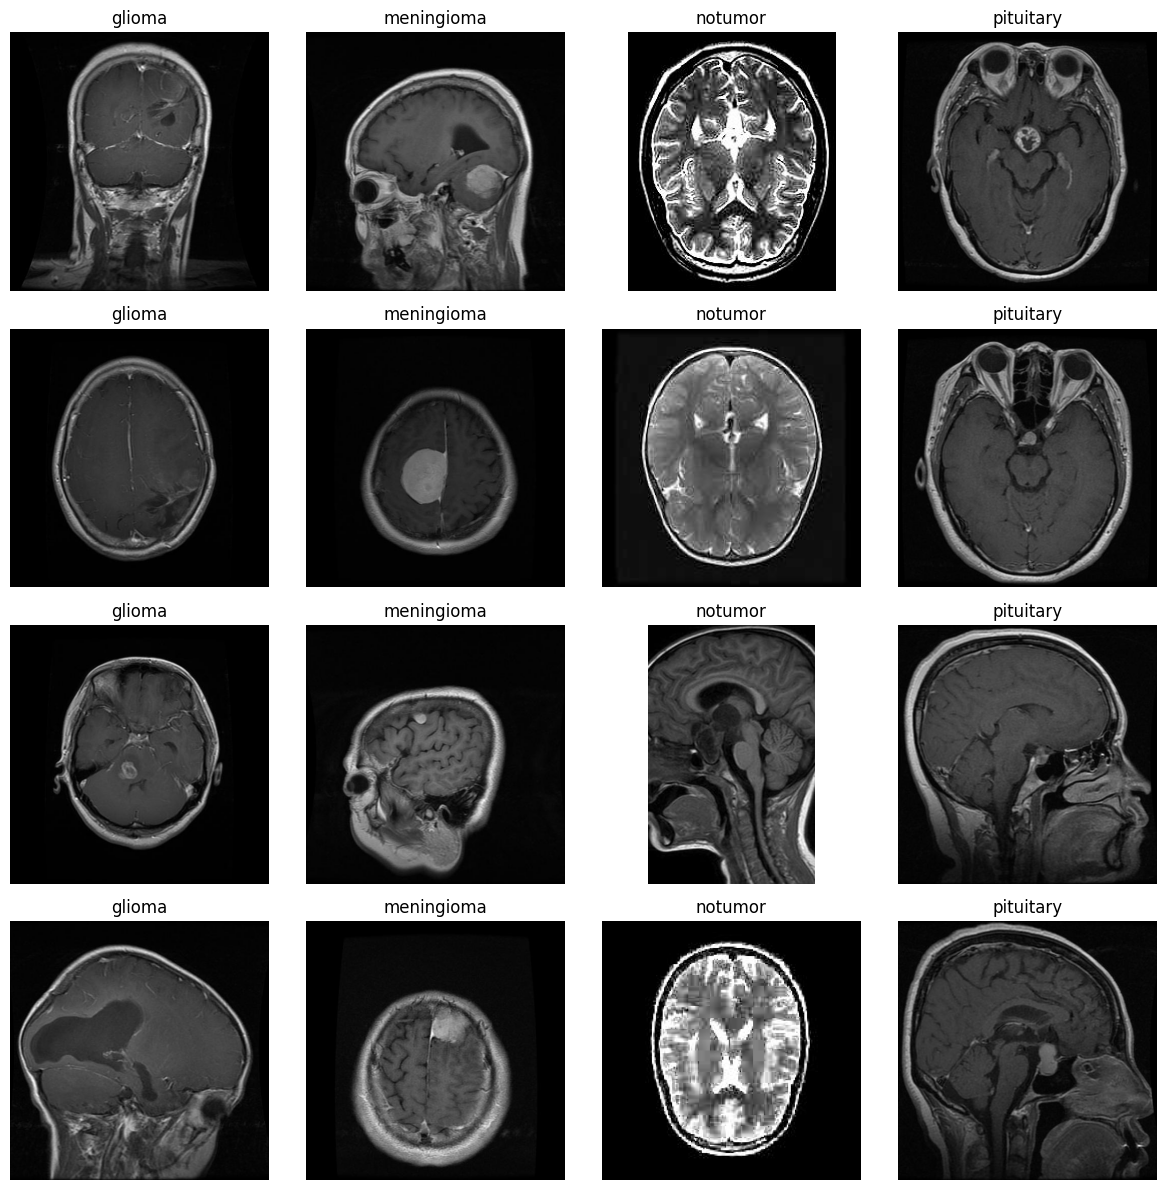

In [36]:
main_folder = 'Training'
subfolders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

# Get images grouped by folder
folder_images = {}
for folder in subfolders:
    path = os.path.join(main_folder, folder)
    images = [os.path.join(path, img) for img in os.listdir(path) 
              if img.endswith(('.jpg', '.png', '.webp'))]
    random.shuffle(images)  # Shuffle images within each folder
    folder_images[folder] = images

# Round-robin selection
selected_images = []
folder_cycle = cycle(subfolders)  # Infinite loop through folders
while len(selected_images) < 16:
    folder = next(folder_cycle)
    if folder_images[folder]:  # If folder still has images
        selected_images.append(folder_images[folder].pop())

# Plot them
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(os.path.basename(os.path.dirname(img_path)))  # Show folder name
plt.tight_layout()
plt.show()

In [37]:
IMAGE_SIZE = 224

BATCH_SIZE = 32

In [38]:
def cnn_preprocess(x):
    return x/255.0

In [39]:
cnn_train_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)
cnn_train_generator = cnn_train_datagen.flow_from_directory(
        train_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 5712 images belonging to 4 classes.


In [40]:
cnn_train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [41]:
cnn_test_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)
cnn_test_generator = cnn_test_datagen.flow_from_directory(
        test_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 6595 images belonging to 5 classes.


In [42]:
cnn_test_generator.class_indices

{'glioma': 0,
 'meningioma': 1,
 'merged_brain_tumor_dataset': 2,
 'notumor': 3,
 'pituitary': 4}

In [43]:
cnn_model = keras.Sequential([
    keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),

    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),

    keras.layers.Dense(units=len(cnn_test_generator.class_indices), activation='softmax', dtype='float32')
])

In [44]:
cnn_model = keras.Sequential([
    keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),

    # First conv block
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # Second conv block
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # Third conv block
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # Fourth conv block (optional - for deeper feature extraction)
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # Dense layers
    keras.layers.GlobalAveragePooling2D(),  # Alternative to Flatten + reduces parameters
    keras.layers.Dense(units=512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    # Output layer
    keras.layers.Dense(units=len(cnn_test_generator.class_indices), activation='softmax', dtype='float32')
])

In [45]:
cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 851,365 (3.25 MB)

 Trainable params: 848,869 (3.24 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [46]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='CNN_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]
cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
              loss=keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy',keras.metrics.Precision(name='precision'),
                                   keras.metrics.Recall(name='recall'),
                                   keras.metrics.F1Score(name='f1_score')
])

In [47]:
cnn_history = cnn_model.fit(
        cnn_train_generator,
        epochs = 5,
        validation_data = cnn_test_generator,
        callbacks = callbacks
        )

Epoch 1/5


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 4), output.shape=(None, 5)

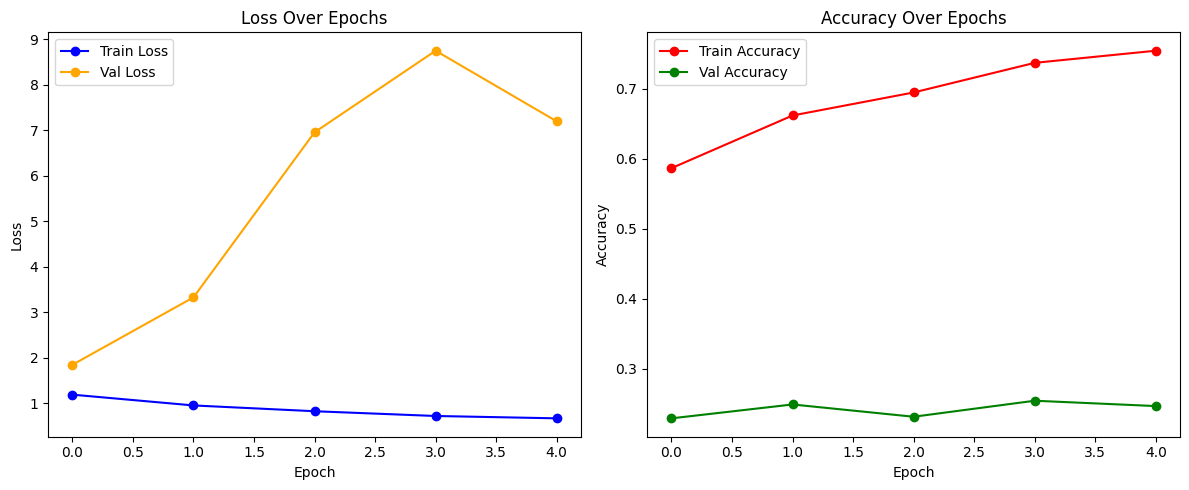

In [ ]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(cnn_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [56]:
def merge_brain_tumor_dataset(base_path, output_path):
    
    # Define the class names (subfolder names)
    classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
    
    # Create output directory structure
    os.makedirs(output_path, exist_ok=True)
    
    for class_name in classes:
        class_output_dir = os.path.join(output_path, class_name)
        os.makedirs(class_output_dir, exist_ok=True)
        print(f"Created directory: {class_output_dir}")
    
    # Copy files from Training and Testing folders
    for folder_type in ['Training', 'Testing']:
        folder_path = os.path.join(base_path, folder_type)
        
        if not os.path.exists(folder_path):
            print(f"Warning: {folder_path} does not exist!")
            continue
            
        print(f"\nProcessing {folder_type} folder...")
        
        for class_name in classes:
            source_dir = os.path.join(folder_path, class_name)
            target_dir = os.path.join(output_path, class_name)
            
            if not os.path.exists(source_dir):
                print(f"Warning: {source_dir} does not exist!")
                continue
            
            # Get all image files from source directory
            image_files = [f for f in os.listdir(source_dir) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
            
            print(f"  {class_name}: Found {len(image_files)} images")
            
            # Copy each image file
            for i, filename in enumerate(image_files):
                source_file = os.path.join(source_dir, filename)
                
                # Add prefix to avoid naming conflicts
                new_filename = f"{folder_type.lower()}_{filename}"
                target_file = os.path.join(target_dir, new_filename)
                
                try:
                    shutil.copy2(source_file, target_file)
                except Exception as e:
                    print(f"Error copying {source_file}: {e}")
            
            print(f"  Copied {len(image_files)} images from {class_name}")
    
    # Print final statistics
    print("\n" + "="*50)
    print("MERGE COMPLETE - Final Statistics:")
    print("="*50)
    
    total_images = 0
    for class_name in classes:
        class_dir = os.path.join(output_path, class_name)
        if os.path.exists(class_dir):
            count = len([f for f in os.listdir(class_dir) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
            print(f"{class_name}: {count} images")
            total_images += count
    
    print(f"\nTotal images in merged dataset: {total_images}")
    print(f"Merged dataset saved to: {output_path}")

# Path to dataset ()
dataset_path = "D:/CA2_DL/Training"  

output_path = "D:/CA2_DL/testing/merged_brain_tumor_dataset"

# Run the merge function
merge_brain_tumor_dataset(dataset_path, output_path)

print("\n" + "="*50)
print("Sample files from merged dataset:")
print("="*50)

for class_name in ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']:
    class_dir = os.path.join(output_path, class_name)
    if os.path.exists(class_dir):
        files = os.listdir(class_dir)[:3]  # Show first 3 files
        print(f"\n{class_name} (showing first 3 files):")
        for file in files:
            print(f"  - {file}")

Created directory: D:/CA2_DL/testing/merged_brain_tumor_dataset\glioma_tumor
Created directory: D:/CA2_DL/testing/merged_brain_tumor_dataset\meningioma_tumor
Created directory: D:/CA2_DL/testing/merged_brain_tumor_dataset\no_tumor
Created directory: D:/CA2_DL/testing/merged_brain_tumor_dataset\pituitary_tumor

MERGE COMPLETE - Final Statistics:
glioma_tumor: 1321 images
meningioma_tumor: 1321 images
no_tumor: 1321 images
pituitary_tumor: 1321 images

Total images in merged dataset: 5284
Merged dataset saved to: D:/CA2_DL/testing/merged_brain_tumor_dataset

Sample files from merged dataset:

glioma_tumor (showing first 3 files):
  - Tr-glTr_0000.jpg
  - Tr-glTr_0001.jpg
  - Tr-glTr_0002.jpg

meningioma_tumor (showing first 3 files):
  - Tr-meTr_0000.jpg
  - Tr-meTr_0001.jpg
  - Tr-meTr_0002.jpg

no_tumor (showing first 3 files):
  - Tr-noTr_0000.jpg
  - Tr-noTr_0002.jpg
  - Tr-noTr_0003.jpg

pituitary_tumor (showing first 3 files):
  - Tr-piTr_0000.jpg
  - Tr-piTr_0001.jpg
  - Tr-piTr_0

In [ ]:
test_path_1= 'Test'

In [ ]:
dataset_path = "Testing/merged_brain_tumor_dataset"
output_path = "Testing/merged_brain_tumor_dataset"

# Get file lists for each class
glioma_files = os.listdir(f"{dataset_path}/glioma_tumor")
meningioma_files = os.listdir(f"{dataset_path}/meningioma_tumor") 
no_tumor_files = os.listdir(f"{dataset_path}/no_tumor")
pituitary_files = os.listdir(f"{dataset_path}/pituitary_tumor")

print("Original distribution:")
print(f"glioma_tumor: {len(glioma_files)}")
print(f"meningioma_tumor: {len(meningioma_files)}")
print(f"no_tumor: {len(no_tumor_files)}")
print(f"pituitary_tumor: {len(pituitary_files)}")

# Find minimum class size
min_size = min(len(glioma_files), len(meningioma_files), len(no_tumor_files), len(pituitary_files))
print(f"\nDownsampling all to: {min_size} samples")

# Downsample each class
glioma_downsampled = resample(glioma_files, 
                             replace=False,
                             n_samples=min_size,
                             random_state=42)

meningioma_downsampled = resample(meningioma_files, 
                                 replace=False,
                                 n_samples=min_size,
                                 random_state=42)

no_tumor_downsampled = resample(no_tumor_files, 
                               replace=False,
                               n_samples=min_size,
                               random_state=42)

pituitary_downsampled = resample(pituitary_files, 
                                replace=False,
                                n_samples=min_size,
                                random_state=42)

# Keep only the downsampled files (delete the rest)
classes = {
    'glioma_tumor': glioma_downsampled,
    'meningioma_tumor': meningioma_downsampled,
    'no_tumor': no_tumor_downsampled,
    'pituitary_tumor': pituitary_downsampled
}

for class_name, keep_files in classes.items():
    class_dir = f"{dataset_path}/{class_name}"
    all_files = os.listdir(class_dir)
    
    # Delete files that are NOT in the downsampled list
    for filename in all_files:
        if filename not in keep_files:
            file_path = f"{class_dir}/{filename}"
            os.remove(file_path)
    
    remaining = len(os.listdir(class_dir))
    print(f"{class_name}: kept {remaining} files")

print("Done!")

Original distribution:
glioma_tumor: 1321
meningioma_tumor: 1339
no_tumor: 1595
pituitary_tumor: 1457

Downsampling all to: 1321 samples
glioma_tumor: kept 1321 files
meningioma_tumor: kept 1321 files
no_tumor: kept 1321 files
pituitary_tumor: kept 1321 files
Done!


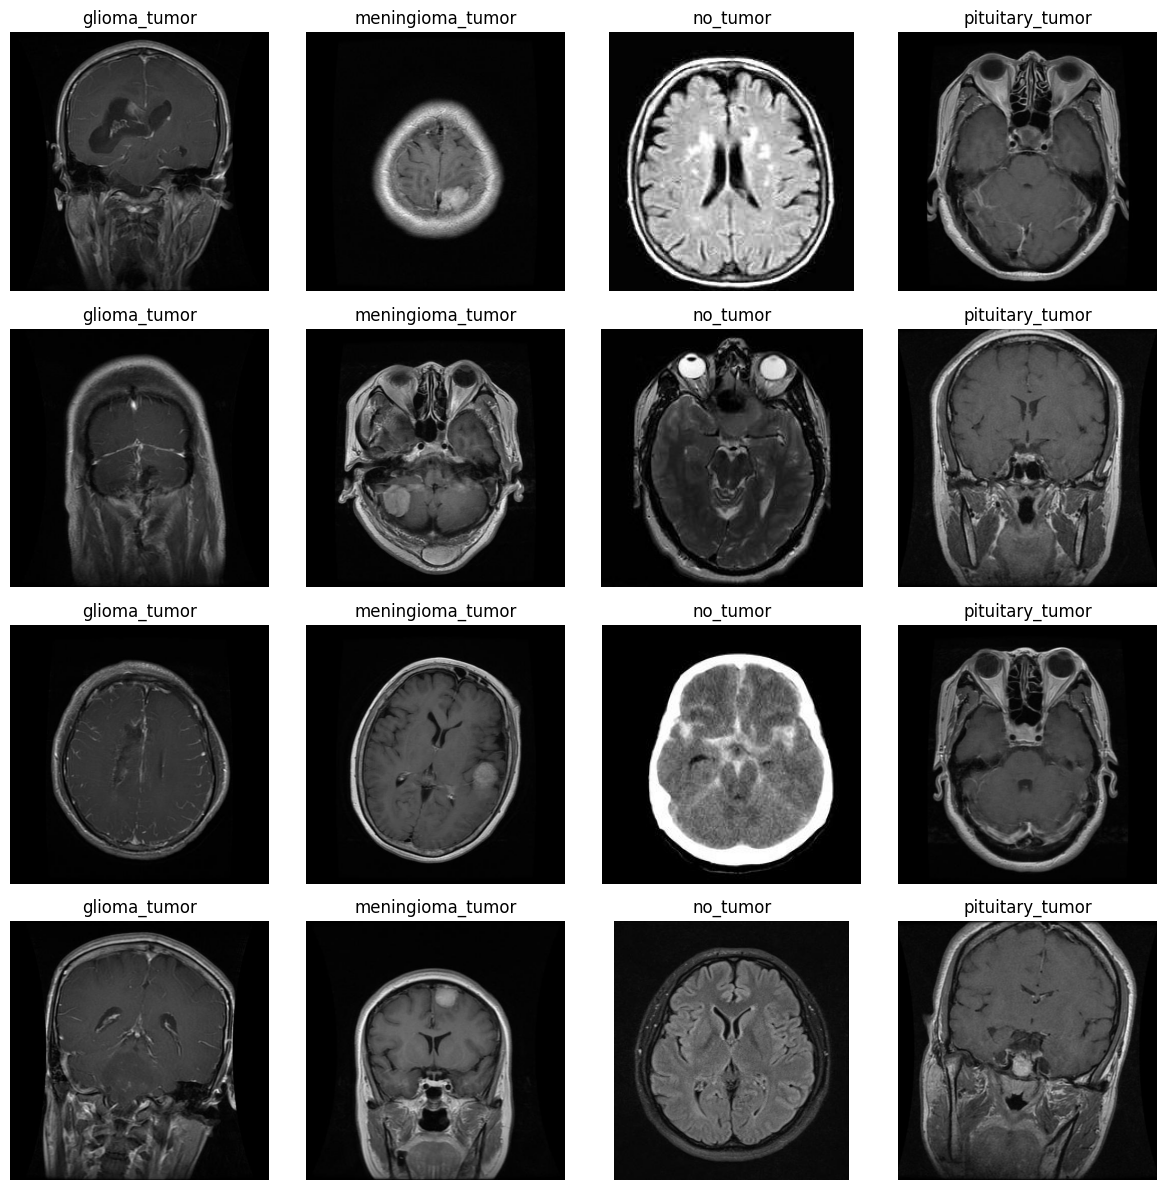

In [ ]:
main_folder = r'Testing/merged_brain_tumor_dataset'
subfolders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

# Get images grouped by folder
folder_images = {}
for folder in subfolders:
    path = os.path.join(main_folder, folder)
    images = [os.path.join(path, img) for img in os.listdir(path) 
              if img.endswith(('.jpg', '.png', '.webp'))]
    random.shuffle(images)  # Shuffle images within each folder
    folder_images[folder] = images

# Round-robin selection
selected_images = []
folder_cycle = cycle(subfolders)  # Infinite loop through folders
while len(selected_images) < 16:
    folder = next(folder_cycle)
    if folder_images[folder]:  # If folder still has images
        selected_images.append(folder_images[folder].pop())

# Plot them
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(os.path.basename(os.path.dirname(img_path)))  # Show folder name
plt.tight_layout()
plt.show()

In [48]:
cnn_merged_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)
cnn_merged_generator = cnn_merged_datagen.flow_from_directory(
        output_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 5284 images belonging to 4 classes.


In [49]:
cnn_predictions = cnn_model.predict(cnn_merged_generator)

166/166 ━━━━━━━━━━━━━━━━━━━━ 87s 521ms/step


In [52]:
cnn_predictions

array([[0.19913177, 0.20018435, 0.20007084, 0.19931345, 0.20129956],
       [0.19883214, 0.20028675, 0.20008786, 0.19920638, 0.20158681],
       [0.19923568, 0.20017408, 0.20005977, 0.1994024 , 0.20112808],
       ...,
       [0.19905238, 0.20019315, 0.20007429, 0.19929597, 0.20138417],
       [0.1990803 , 0.20024015, 0.20004937, 0.19927758, 0.20135255],
       [0.19879463, 0.20028512, 0.20009704, 0.1991883 , 0.20163484]],
      dtype=float32)